비어플 4주차 과제_백주원
=============
적합한 모델 선정하고 분석
-----------

## 1. 라이브러리 설치 및 데이터 불러오기

In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import os

In [681]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

In [682]:
os.getcwd() #현재 작업 위치 출력

'c:\\Users\\foma\\Desktop\\jjuwar\\비어플\\신입세션'

In [683]:
train = pd.read_csv('./data/train.csv', encoding =  "ISO-8859-1")
test = pd.read_csv('./data/test.csv', encoding =  "ISO-8859-1")

In [684]:
test.isna().sum()

Date                            0
Hour                            0
Temperature(¡ÆC)              174
Humidity(%)                     0
Wind speed (m/s)              171
Visibility (10m)                0
Dew point temperature(¡ÆC)      0
Solar Radiation (MJ/m2)         0
Rainfall(mm)                    0
Snowfall (cm)                   0
Seasons                       177
Holiday                         0
Functioning Day                 0
dtype: int64

## 2. 1차 전처리

2.1 변수 정리 

In [685]:
# 날짜 데이터로 데이터타입 변환
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')

# 날짜 기준으로 정렬
train = train.sort_values(by='Date')

In [686]:
test['Date'] = pd.to_datetime(test['Date'] , format='%d/%m/%Y')
test = test.sort_values(by='Date')

In [687]:
# 운행 안 하는 날 행 제거 
train = train[train['Functioning Day'] != 'No' ]  

In [688]:
test = test[test['Functioning Day'] != 'No' ]  

2.2 파생변수 생성
- 강수량 유무, 강설량 유무,시간대 변수 생성

In [689]:
# 강수량 유무로 나누는 변수 생성
train['RR'] = train['Rainfall(mm)'].apply(lambda x: 1 if x > 0 else 0)
train['RR'].value_counts()

RR
0    6362
1     410
Name: count, dtype: int64

In [690]:
test['RR'] = test['Rainfall(mm)'].apply(lambda x: 1 if x > 0 else 0)
test['RR'].value_counts()

RR
0    1587
1     106
Name: count, dtype: int64

In [691]:
# 강설량 유무로 나누는 변수 생성
train['SS'] = train['Snowfall (cm)'].apply(lambda x: 1 if x > 0 else 0)
train['SS'].value_counts()

SS
0    6416
1     356
Name: count, dtype: int64

In [692]:
test['SS'] = test['Snowfall (cm)'].apply(lambda x: 1 if x > 0 else 0)
test['SS'].value_counts()

SS
0    1606
1      87
Name: count, dtype: int64

In [693]:
# 시간대를 나누는 함수 정의
def time_period(hour):
    if 6 <= hour <= 12:
        return 'Morning'
    elif 12 < hour <= 18:
        return 'Afternoon'
    elif 18 < hour <= 24:
        return 'Evening'
    else:
        return 'Dawn'

# 시간대 열 추가
train['Time Period'] = train['Hour'].apply(time_period)

In [694]:
# 시간대 열 추가
test['Time Period'] = test['Hour'].apply(time_period)

In [695]:
train.columns = ['Date', 'Rent', 'Hour', 'Temp', 'Humid',
       'Windsp', 'Visibil', 'Dew point temp',
       'SolarRad', 'Rain', 'Snow', 'Seasons',
       'Holiday', 'Functioning Day','RR','SS' ,'Time Period']

In [696]:
test.columns = ['Date', 'Hour', 'Temp', 'Humid',
       'Windsp', 'Visibil', 'Dew point temp',
       'SolarRad', 'Rain', 'Snow', 'Seasons',
       'Holiday', 'Functioning Day','RR','SS' ,'Time Period']

2.3 결측치 처리
- 계절, 기온, 풍속

In [697]:
# 계절 변수 결측치 처리

train['Month'] = train['Date'].dt.month

for index, row in train.iterrows():
    if (row['Month'] == 3) | (row['Month'] == 4) |(row['Month'] == 5) :
        train.at[index, 'Seasons'] = 'Spring'
    elif(row['Month'] == 6) | (row['Month'] == 7) |(row['Month'] == 8):
        train.at[index, 'Seasons'] = 'Summer'
    elif(row['Month'] == 9) | (row['Month'] == 10) |(row['Month'] == 11):
        train.at[index, 'Seasons'] = 'Autumn'
    else:
        train.at[index, 'Seasons'] = 'Winter'

In [698]:
test['Month'] = test['Date'].dt.month

for index, row in test.iterrows():
    if (row['Month'] == 3) | (row['Month'] == 4) |(row['Month'] == 5) :
        test.at[index, 'Seasons'] = 'Spring'
    elif(row['Month'] == 6) | (row['Month'] == 7) |(row['Month'] == 8):
        test.at[index, 'Seasons'] = 'Summer'
    elif(row['Month'] == 9) | (row['Month'] == 10) |(row['Month'] == 11):
        test.at[index, 'Seasons'] = 'Autumn'
    else:
        test.at[index, 'Seasons'] = 'Winter'

In [699]:
# 기온 결측치 처리
# Simplified Empirical Formula 이용

def fill_missing_temperature(row):
    if np.isnan(row['Temp']):
        return row['Dew point temp'] + ((100 - row['Humid']) / 10) * 2
    else:
        return row['Temp']

train['Temp'] = train.apply(fill_missing_temperature, axis=1)

In [700]:
train['Temp'].describe()

count    6772.000000
mean       12.743650
std        12.129822
min       -17.800000
25%         3.100000
50%        13.400000
75%        22.700000
max        39.400000
Name: Temp, dtype: float64

In [701]:
train['Temp'] = train['Temp'].round(3)

In [702]:
test['Temp'] = test.apply(fill_missing_temperature, axis=1)

In [703]:
# 풍속 결측치 처리 
# 스플라인 보간법_2 : interp1d함수 이용해서 보간

from scipy.interpolate import interp1d

# 결측치가 아닌 데이터의 인덱스와 값 추출
x = train.index[~train['Windsp'].isna()]
y = train['Windsp'].dropna()

# interp1d를 사용하여 보간 함수 생성
f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
# 3차 스플라인 보간
## 데이터 범위를 초과한 값에 대해서도 보간

# 모든 인덱스에 대해 보간 수행
train['Windsp'] = f(train.index)

In [704]:
x = test.index[~test['Windsp'].isna()]
y = test['Windsp'].dropna()

f = interp1d(x, y, kind='cubic', fill_value='extrapolate')

test['Windsp'] = f(test.index)

In [705]:
train.isna().sum()

Date               0
Rent               0
Hour               0
Temp               0
Humid              0
Windsp             0
Visibil            0
Dew point temp     0
SolarRad           0
Rain               0
Snow               0
Seasons            0
Holiday            0
Functioning Day    0
RR                 0
SS                 0
Time Period        0
Month              0
dtype: int64

In [706]:
test.isna().sum()

Date               0
Hour               0
Temp               0
Humid              0
Windsp             0
Visibil            0
Dew point temp     0
SolarRad           0
Rain               0
Snow               0
Seasons            0
Holiday            0
Functioning Day    0
RR                 0
SS                 0
Time Period        0
Month              0
dtype: int64

2.4 이상치 처리
- 습도 0 이상치 처리

In [707]:
train['Humid'] = train['Humid'].replace(0, np.nan)

# 스플라인 보간법 : interp1d함수 이용해서 보간

from scipy.interpolate import interp1d

# 결측치가 아닌 데이터의 인덱스와 값 추출
x = train.index[~train['Humid'].isna()]
y = train['Humid'].dropna()

# interp1d를 사용하여 보간 함수 생성
f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
# 3차 스플라인 보간
## 데이터 범위를 초과한 값에 대해서도 보간

# 모든 인덱스에 대해 보간 수행
train['Humid'] = f(train.index)

In [708]:
test['Humid'] = test['Humid'].replace(0, np.nan)

x = test.index[~test['Humid'].isna()]
y = test['Humid'].dropna()

f = interp1d(x, y, kind='cubic', fill_value='extrapolate')

test['Humid'] = f(test.index)

## 3. 2차 전처리
- 1) 범주형 변수 수치화
- 2) 변수 선택
- 3) Train/Valid 셋분리
- 4) 스케일링

\* 모델링에 사용할 변수 : 시간대,계절,휴일|기온,상대습도,풍속,가시성,이슬점,태양복사량,강수량,강설량
<br>\* 범주형 변수의 값이 너무 많은 것은 구간을 나눈 파생변수를 만들어 사용

- 범주형 데이터 
  - 명목형 변수 : 계절,휴일,시간대,강수여부,강설여부 (시간변수는 명목형)
  - 순서형 변수 : X
- 수치형 데이터 : 기온,상대습도,풍속,가시성,이슬점,태양복사량

### 3.1 범주형 변수 수치화

3.1.1 명목형 변수 수치화

In [709]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder(drop='first', sparse_output=False) 
## drop='first'로 다중공선성 방지, sparse_output=False로 희소행렬이 아닌 밀집행렬로 반환

# 'Seasons','Holiday' 열을 원핫 인코딩
encoded_columns = encoder.fit_transform(train[['Seasons', 'Holiday','Time Period','RR','SS']])

In [710]:
encoder.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object),
 array(['Afternoon', 'Dawn', 'Evening', 'Morning'], dtype=object),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64)]

In [711]:
# 데이터를 데이터프레임으로 변환
encoded_train = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['Seasons', 'Holiday','Time Period','RR','SS']))

In [712]:
encoded_train

,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6767,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6768,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6769,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6770,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [713]:
# 인덱스 맞추기
train = train.reset_index(drop=True)
train.drop(['Seasons', 'Holiday','Time Period','RR','SS'], axis=1)

,Date,Rent,Hour,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Rain,Snow,Functioning Day,Month
0,2017-12-01,181,6,-6.5,35.0,1.3,2000,-19.5,0.00,0.0,0.0,Yes,12
1,2017-12-01,107,3,-6.2,40.0,0.9,2000,-17.6,0.00,0.0,0.0,Yes,12
2,2017-12-01,447,14,3.0,26.0,2.0,2000,-14.6,1.01,0.0,0.0,Yes,12
3,2017-12-01,173,2,-6.0,39.0,1.0,2000,-17.7,0.00,0.0,0.0,Yes,12
4,2017-12-01,398,22,0.0,83.0,1.5,1380,-3.4,0.00,0.0,0.0,Yes,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767,2018-11-30,720,12,6.6,35.0,1.3,1409,-7.8,1.70,0.0,0.0,Yes,11
6768,2018-11-30,116,4,0.7,71.0,0.4,1345,-5.1,0.00,0.0,0.0,Yes,11
6769,2018-11-30,456,1,1.3,63.0,2.0,1379,-4.9,0.00,0.0,0.0,Yes,11
6770,2018-11-30,740,13,7.1,24.0,2.8,1838,-12.1,1.83,0.0,0.0,Yes,11


In [714]:
train_onehot = pd.concat([train.drop(['Seasons', 'Holiday','Time Period','RR','SS'], axis=1), encoded_train],axis =1)

In [715]:
train_onehot

,Date,Rent,Hour,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Rain,Snow,Functioning Day,Month,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
0,2017-12-01,181,6,-6.5,35.0,1.3,2000,-19.5,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2017-12-01,107,3,-6.2,40.0,0.9,2000,-17.6,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2017-12-01,447,14,3.0,26.0,2.0,2000,-14.6,1.01,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2017-12-01,173,2,-6.0,39.0,1.0,2000,-17.7,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2017-12-01,398,22,0.0,83.0,1.5,1380,-3.4,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767,2018-11-30,720,12,6.6,35.0,1.3,1409,-7.8,1.70,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6768,2018-11-30,116,4,0.7,71.0,0.4,1345,-5.1,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6769,2018-11-30,456,1,1.3,63.0,2.0,1379,-4.9,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6770,2018-11-30,740,13,7.1,24.0,2.8,1838,-12.1,1.83,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [716]:
encoded_columns_test = encoder.fit_transform(test[['Seasons', 'Holiday','Time Period','RR','SS']])
encoded_test = pd.DataFrame(encoded_columns_test, 
                             columns=encoder.get_feature_names_out(['Seasons', 'Holiday','Time Period','RR','SS']))
test = test.reset_index(drop=True)
test.drop(['Seasons', 'Holiday','Time Period','RR','SS'], axis=1)
test_onehot = pd.concat([test.drop(['Seasons', 'Holiday','Time Period','RR','SS'], axis=1), encoded_test],axis =1)

In [717]:
test_onehot

,Date,Hour,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Rain,Snow,Functioning Day,Month,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
0,2017-12-01,17,0.8,58.0,1.6,2000,-6.5,0.08,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2017-12-02,20,4.6,51.0,1.2,1585,-4.6,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2017-12-02,11,1.9,49.0,1.8,1406,-7.7,1.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2017-12-02,9,-2.9,68.0,1.6,1487,-7.9,0.30,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2017-12-02,1,-2.2,86.0,0.6,990,-4.2,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,2018-11-30,20,3.4,37.0,2.3,2000,-9.9,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1689,2018-11-30,10,1.9,51.0,0.8,1029,-7.1,1.01,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1690,2018-11-30,16,7.2,23.0,1.5,1945,-12.6,0.72,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1691,2018-11-30,0,1.8,62.0,1.6,1411,-4.7,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [718]:
train = train_onehot
test = test_onehot

3.1.1 순서형 변수 수치화
- 순서형 변수 없음

### 3.2 변수 선택

In [719]:
train

,Date,Rent,Hour,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Rain,Snow,Functioning Day,Month,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
0,2017-12-01,181,6,-6.5,35.0,1.3,2000,-19.5,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2017-12-01,107,3,-6.2,40.0,0.9,2000,-17.6,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2017-12-01,447,14,3.0,26.0,2.0,2000,-14.6,1.01,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2017-12-01,173,2,-6.0,39.0,1.0,2000,-17.7,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2017-12-01,398,22,0.0,83.0,1.5,1380,-3.4,0.00,0.0,0.0,Yes,12,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767,2018-11-30,720,12,6.6,35.0,1.3,1409,-7.8,1.70,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6768,2018-11-30,116,4,0.7,71.0,0.4,1345,-5.1,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6769,2018-11-30,456,1,1.3,63.0,2.0,1379,-4.9,0.00,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6770,2018-11-30,740,13,7.1,24.0,2.8,1838,-12.1,1.83,0.0,0.0,Yes,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [720]:
train = train.drop(['Date', 'Hour','Rain', 'Snow', 'Functioning Day','Month'],axis=1)
test = test.drop(['Date', 'Hour','Rain', 'Snow', 'Functioning Day','Month'],axis=1)

In [721]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6772 entries, 0 to 6771
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rent                 6772 non-null   int64  
 1   Temp                 6772 non-null   float64
 2   Humid                6772 non-null   float64
 3   Windsp               6772 non-null   float64
 4   Visibil              6772 non-null   int64  
 5   Dew point temp       6772 non-null   float64
 6   SolarRad             6772 non-null   float64
 7   Seasons_Spring       6772 non-null   float64
 8   Seasons_Summer       6772 non-null   float64
 9   Seasons_Winter       6772 non-null   float64
 10  Holiday_No Holiday   6772 non-null   float64
 11  Time Period_Dawn     6772 non-null   float64
 12  Time Period_Evening  6772 non-null   float64
 13  Time Period_Morning  6772 non-null   float64
 14  RR_1                 6772 non-null   float64
 15  SS_1                 6772 non-null   f

In [722]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp                 1693 non-null   float64
 1   Humid                1693 non-null   float64
 2   Windsp               1693 non-null   float64
 3   Visibil              1693 non-null   int64  
 4   Dew point temp       1693 non-null   float64
 5   SolarRad             1693 non-null   float64
 6   Seasons_Spring       1693 non-null   float64
 7   Seasons_Summer       1693 non-null   float64
 8   Seasons_Winter       1693 non-null   float64
 9   Holiday_No Holiday   1693 non-null   float64
 10  Time Period_Dawn     1693 non-null   float64
 11  Time Period_Evening  1693 non-null   float64
 12  Time Period_Morning  1693 non-null   float64
 13  RR_1                 1693 non-null   float64
 14  SS_1                 1693 non-null   float64
dtypes: float64(14), int64(1)
memory usage:

In [723]:
X_train

array([[-0.95983982, -1.57400862,  0.35552063, ..., -0.63826212,
        -0.25346324, -0.23565633],
       [ 1.2580224 ,  0.52939525, -0.58089596, ...,  1.56675441,
        -0.25346324, -0.23565633],
       [-1.46277511,  1.31205715, -0.85741761, ..., -0.63826212,
        -0.25346324,  4.24346763],
       ...,
       [ 0.63965933,  1.89905358,  0.06754184, ..., -0.63826212,
         3.94534526, -0.23565633],
       [ 0.13672403, -0.64459761, -1.08437333, ..., -0.63826212,
        -0.25346324, -0.23565633],
       [ 0.16145855, -0.15543392, -0.12444403, ..., -0.63826212,
        -0.25346324, -0.23565633]])

### 3.3 Train/Valid 셋분리

In [724]:
#X(독립변수), y(종속변수) 분리
X = train.drop("Rent", axis=1)
y = train["Rent"]

In [725]:
#train과 valid 셋 분리

X_train1, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5417, 15) (1355, 15) (5417,) (1355,)


In [726]:
X_train

array([[-0.95983982, -1.57400862,  0.35552063, ..., -0.63826212,
        -0.25346324, -0.23565633],
       [ 1.2580224 ,  0.52939525, -0.58089596, ...,  1.56675441,
        -0.25346324, -0.23565633],
       [-1.46277511,  1.31205715, -0.85741761, ..., -0.63826212,
        -0.25346324,  4.24346763],
       ...,
       [ 0.63965933,  1.89905358,  0.06754184, ..., -0.63826212,
         3.94534526, -0.23565633],
       [ 0.13672403, -0.64459761, -1.08437333, ..., -0.63826212,
        -0.25346324, -0.23565633],
       [ 0.16145855, -0.15543392, -0.12444403, ..., -0.63826212,
        -0.25346324, -0.23565633]])

In [727]:
X_train1

,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
1222,1.1,26.0,2.100000,1957,-16.3,0.82,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4365,28.0,69.0,1.124494,1140,21.7,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
337,-5.0,85.0,0.836430,186,-7.1,0.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1035,-6.0,76.0,3.100000,1178,-9.5,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
818,-8.2,28.0,2.300000,1990,-22.6,1.14,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,10.1,78.0,0.100000,1887,6.4,0.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
79,2.8,89.0,1.500000,130,1.1,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3927,20.5,97.0,1.800000,257,20.0,0.15,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5955,14.4,45.0,0.600000,1206,2.6,1.28,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [728]:
x_test = test.copy()

### 3.4 변수 스케일링

In [729]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train1)
X_val = ss.transform(X_val)
x_test = ss.transform(x_test)

print("<train 셋>")
print(f'평균: {X_train_Ss.mean()}\n분산: {X_train_Ss.std()}')
print("<valid 셋>")
print(f'평균: {X_val_Ss.mean()}\n분산: {X_val_Ss.std()}')

<train 셋>
평균: 2.955675893014754e-17
분산: 1.0
<valid 셋>
평균: -0.005216189951528577
분산: 1.0064978777313303


In [730]:
X_train

array([[-0.95983982, -1.57400862,  0.35552063, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [ 1.2580224 ,  0.52939525, -0.58089596, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [-1.46277511,  1.31205715, -0.85741761, ...,  1.56464763,
        -0.25346324,  4.24346763],
       ...,
       [ 0.63965933,  1.89905358,  0.06754184, ...,  1.56464763,
         3.94534526, -0.23565633],
       [ 0.13672403, -0.64459761, -1.08437333, ...,  1.56464763,
        -0.25346324, -0.23565633],
       [ 0.16145855, -0.15543392, -0.12444403, ..., -0.63912154,
        -0.25346324, -0.23565633]])

In [731]:
X_train1

,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1
1222,1.1,26.0,2.100000,1957,-16.3,0.82,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4365,28.0,69.0,1.124494,1140,21.7,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
337,-5.0,85.0,0.836430,186,-7.1,0.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1035,-6.0,76.0,3.100000,1178,-9.5,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
818,-8.2,28.0,2.300000,1990,-22.6,1.14,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,10.1,78.0,0.100000,1887,6.4,0.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
79,2.8,89.0,1.500000,130,1.1,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3927,20.5,97.0,1.800000,257,20.0,0.15,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5955,14.4,45.0,0.600000,1206,2.6,1.28,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [732]:
data = X_train

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

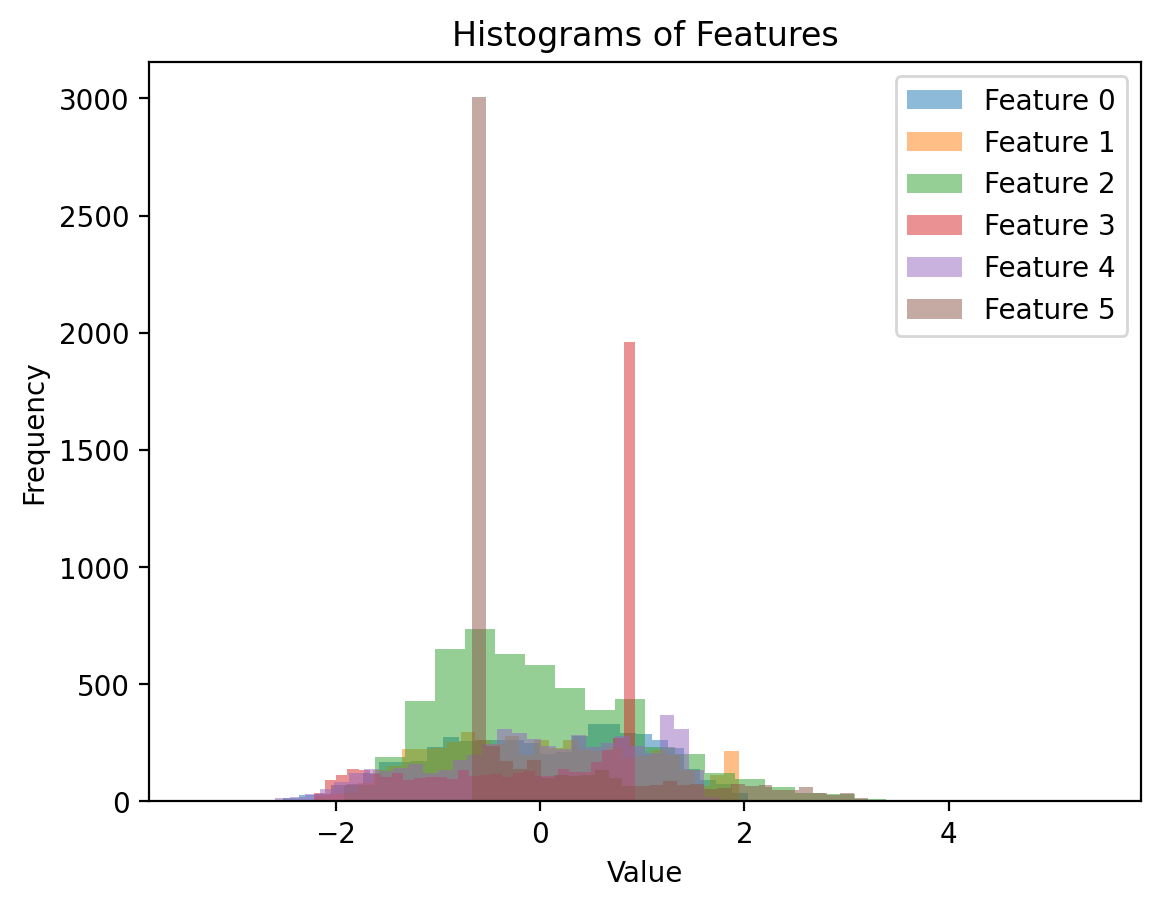

In [733]:
for i in range(6):
    plt.hist(data[:, i], bins=30, alpha=0.5, label=f'Feature {i}')

plt.title('Histograms of Features')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

수치형(연속형) 변수인 train의 0~5열의 히스토그램을 각각 그려봤을 때, 표준화가 된 것을 확인할 수 있다.  

## 4. 모델 학습

1. 회귀,분류 중 > 종속변수가 '대여량'인 연속적인 값이므로 회귀 모델
2. 모델 후보 : 선형회귀, 결정트리 회귀, 랜덤 포레스트 회귀, XGBoost
3. 모델 각각에 맞는 스케일링 후 학습 
4. 평가 지표 비교 후 가장 적합한 모델 선정

- 선형 회귀: 표준화 (Standardization) - 데이터의 스케일을 통일하여 모델 학습을 안정화.
- 결정 트리 회귀: 스케일링 필요 없음 - 특성의 스케일에 영향을 받지 않음.
- 랜덤 포레스트 회귀: 스케일링 필요 없음 - 특성의 스케일에 영향을 받지 않음.
- XGBoost: 스케일링 필요 없음 - 특성의 스케일에 영향을 덜 받음, 그러나 데이터 전처리는 여전히 중요.
- 표준화 진행된 상태의 데이터로 모든 모델에 적용하겠음 X_train X_val y_val

### 4.1 선형회귀 

#### (1) 모델 선언

In [734]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()

#### (2) 모델 학습

In [735]:
model1.fit(X_train, y_train)

LinearRegression()

#### (3) 모델 평가

In [736]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def model_eval(model,y_test, y_pred=None):
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, y_pred)
    print("MSE: %f" % (mse))
    print("RMSE: %f" % (rmse))
    print("MAE: %f" % (mae))
    print("R^2 (Coefficient of Determination): %f" % r2)

In [737]:
pred = model1.predict(X_val)
model_eval(model1,y_val, pred)

MSE: 176033.003266
RMSE: 419.562872
MAE: 313.559409
R^2 (Coefficient of Determination): 0.588551


### 4.2 결정트리 회귀

#### (1) 모델 선언

In [738]:
from sklearn.tree import DecisionTreeRegressor

model2 = DecisionTreeRegressor()

#### (2) 모델 학습

In [739]:
model2.fit(X_train, y_train)  # 스케일링 필요 없음

DecisionTreeRegressor()

#### (3) 모델 평가

In [740]:
pred = model2.predict(X_val)
model_eval(model2,y_val, pred)

MSE: 180465.850923
RMSE: 424.812725
MAE: 276.777860
R^2 (Coefficient of Determination): 0.578190


### 4.3 랜덤포레스트 회귀

#### (1) 모델 선언

In [741]:
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor()

#### (2) 모델 학습

In [742]:
model3.fit(X_train, y_train)  # 스케일링 필요 없음

RandomForestRegressor()

#### (3) 모델 평가

In [743]:
pred = model3.predict(X_val)
model_eval(model3,y_val, pred)

MSE: 93861.409214
RMSE: 306.368094
MAE: 208.391889
R^2 (Coefficient of Determination): 0.780614


### 4.4 XGBoost

#### (1) 모델 선언

In [744]:
from xgboost import XGBRegressor

model4 = XGBRegressor()

#### (2) 모델 학습

In [745]:
model4.fit(X_train, y_train)  # 스케일링 필요 없음

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### (3) 모델 평가

In [746]:
pred = model4.predict(X_val)
model_eval(model4,y_val, pred)

MSE: 101521.444249
RMSE: 318.624300
MAE: 220.793995
R^2 (Coefficient of Determination): 0.762710


[모델 선정 및 근거]
- MSE(평균 제곱 오차) : MSE 값이 낮을수록 모델이 오차를 최소화하고 있음을 의미한다.
- RMSE(평균 제곱근 오차) : MSE의 제곱근으로, 실제 값과 예측 값 사이의 평균적 오차 크기를 원래 단위로 나타낸다. 따라서 RMSE가 낮을수록 모델의 예측이 더 정확하다. 
- MAE(평균 절대 오차) : MAE는 예측값과 실제값 사이의 절대적 차이의 평균을 나타내며, 이 값이 작을수록 모델의 예측이 전반적으로 더 정확함을 의미한다. 
- R2(결정계수) : R² 값은 0과 1 사이의 값을 가지며, 1에 가까울수록 모델이 데이터를 잘 설명한다는 의미이다. 

모델 3(랜덤포레스트 회귀)은 MSE, RMSE, MAE (오차 지표)에서 가장 낮은 값을 기록했으며, R² 또한 가장 높은 값을 보였다. 이는 모델 3이 전반적으로 다른 모델들보다 더 정확하고, 데이터의 변동성을 잘 설명하는 모델임을 나타낸다.
**랜덤포레스트 모델로 결정**

## 5. 하이퍼파라미터 튜닝

[랜덤포레스트 회귀 모델의 하이퍼파라미터]
- `n_estimators` : 랜덤 포레스트를 구성하는 결정 트리의 개수 / 기본값: 100 / 보통 100~500 값 시도
- `max_dept` : 각 결정 트리의 최대 깊이 / 클수록 과적합 / 기본값: None / 보통 10~30 값 시도
- `min_samples_split` : 내부 노드를 분할하기 위해 필요한 최소 샘플 수 / 기본값: 2 / 값 늘리면 모델 더 단순 / 일반적으로 2, 5, 10 등의 값 시도
- `min_samples_leaf` : 리프 노드에 있어야 하는 최소 샘플 수 / 기본값 : 1 / 값 늘리면 모델 더 단순 / 일반적으로 1, 5, 10 등의 값 시도
- `max_features` : 각 결정 트리에서 분할에 사용할 특성의 최대 개수 / 기본값: auto / auto, sqrt, log2 시도
- `bootstrap` : 부트스트랩 샘플링을 사용할지 여부 / 기본값: True / False했을 때와 성능 비교해봐
- `random_stat` : 랜덤 시드를 설정하여 결과의 재현성을 보장 / 기본값 : None 
- `n_jobs` : 트리 학습 및 예측에 사용할 CPU 코어 수를 설정 / 기본값: None / 학습 시간을 줄이기 위해 -1로 설정하는 것이 일반적

### 5.1 Grid Search

In [747]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델 인스턴스 생성
rf = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV로 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [748]:
X_train

array([[-0.95983982, -1.57400862,  0.35552063, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [ 1.2580224 ,  0.52939525, -0.58089596, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [-1.46277511,  1.31205715, -0.85741761, ...,  1.56464763,
        -0.25346324,  4.24346763],
       ...,
       [ 0.63965933,  1.89905358,  0.06754184, ...,  1.56464763,
         3.94534526, -0.23565633],
       [ 0.13672403, -0.64459761, -1.08437333, ...,  1.56464763,
        -0.25346324, -0.23565633],
       [ 0.16145855, -0.15543392, -0.12444403, ..., -0.63912154,
        -0.25346324, -0.23565633]])

In [749]:
grid_search.best_score_

0.7853043439905439

In [750]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [751]:
best_model = grid_search.best_estimator_

In [752]:
pred = best_model.predict(X_val)
model_eval(best_model,y_val, pred)

MSE: 90709.763685
RMSE: 301.180616
MAE: 207.126085
R^2 (Coefficient of Determination): 0.787980


전체적으로 모두 성능이 좋아짐

### 5.2 Randomized Search
하이퍼파라미터의 조합 중 임의의 일부를 샘플링하여 최적의 값을 찾는 방법이다.

In [769]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# 랜덤 포레스트 모델 인스턴스 생성
rf = RandomForestRegressor(random_state=42)

# 하이퍼파라미터의 범위 설정
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV로 하이퍼파라미터 튜닝
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A295408A10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A295F3F7A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A292DDA000>},
                   random_state=42, verbose=2)

In [770]:
random_search.best_score_
best_model_2 = random_search.best_estimator_

In [771]:
pred = best_model_2.predict(X_val)
model_eval(best_model_2 ,y_val, pred)

MSE: 90608.669630
RMSE: 301.012740
MAE: 207.045542
R^2 (Coefficient of Determination): 0.788217


Grid Search보다 성능이 약간 더 좋음. Randomized Search로 채택

## 6. 변수 선택

In [753]:
X_train

array([[-0.95983982, -1.57400862,  0.35552063, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [ 1.2580224 ,  0.52939525, -0.58089596, ..., -0.63912154,
        -0.25346324, -0.23565633],
       [-1.46277511,  1.31205715, -0.85741761, ...,  1.56464763,
        -0.25346324,  4.24346763],
       ...,
       [ 0.63965933,  1.89905358,  0.06754184, ...,  1.56464763,
         3.94534526, -0.23565633],
       [ 0.13672403, -0.64459761, -1.08437333, ...,  1.56464763,
        -0.25346324, -0.23565633],
       [ 0.16145855, -0.15543392, -0.12444403, ..., -0.63912154,
        -0.25346324, -0.23565633]])

In [776]:
# 변수 중요도 계산
importances_values = pd.Series(best_model_2.feature_importances_, index=X_train1.columns).sort_values(ascending=False)

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

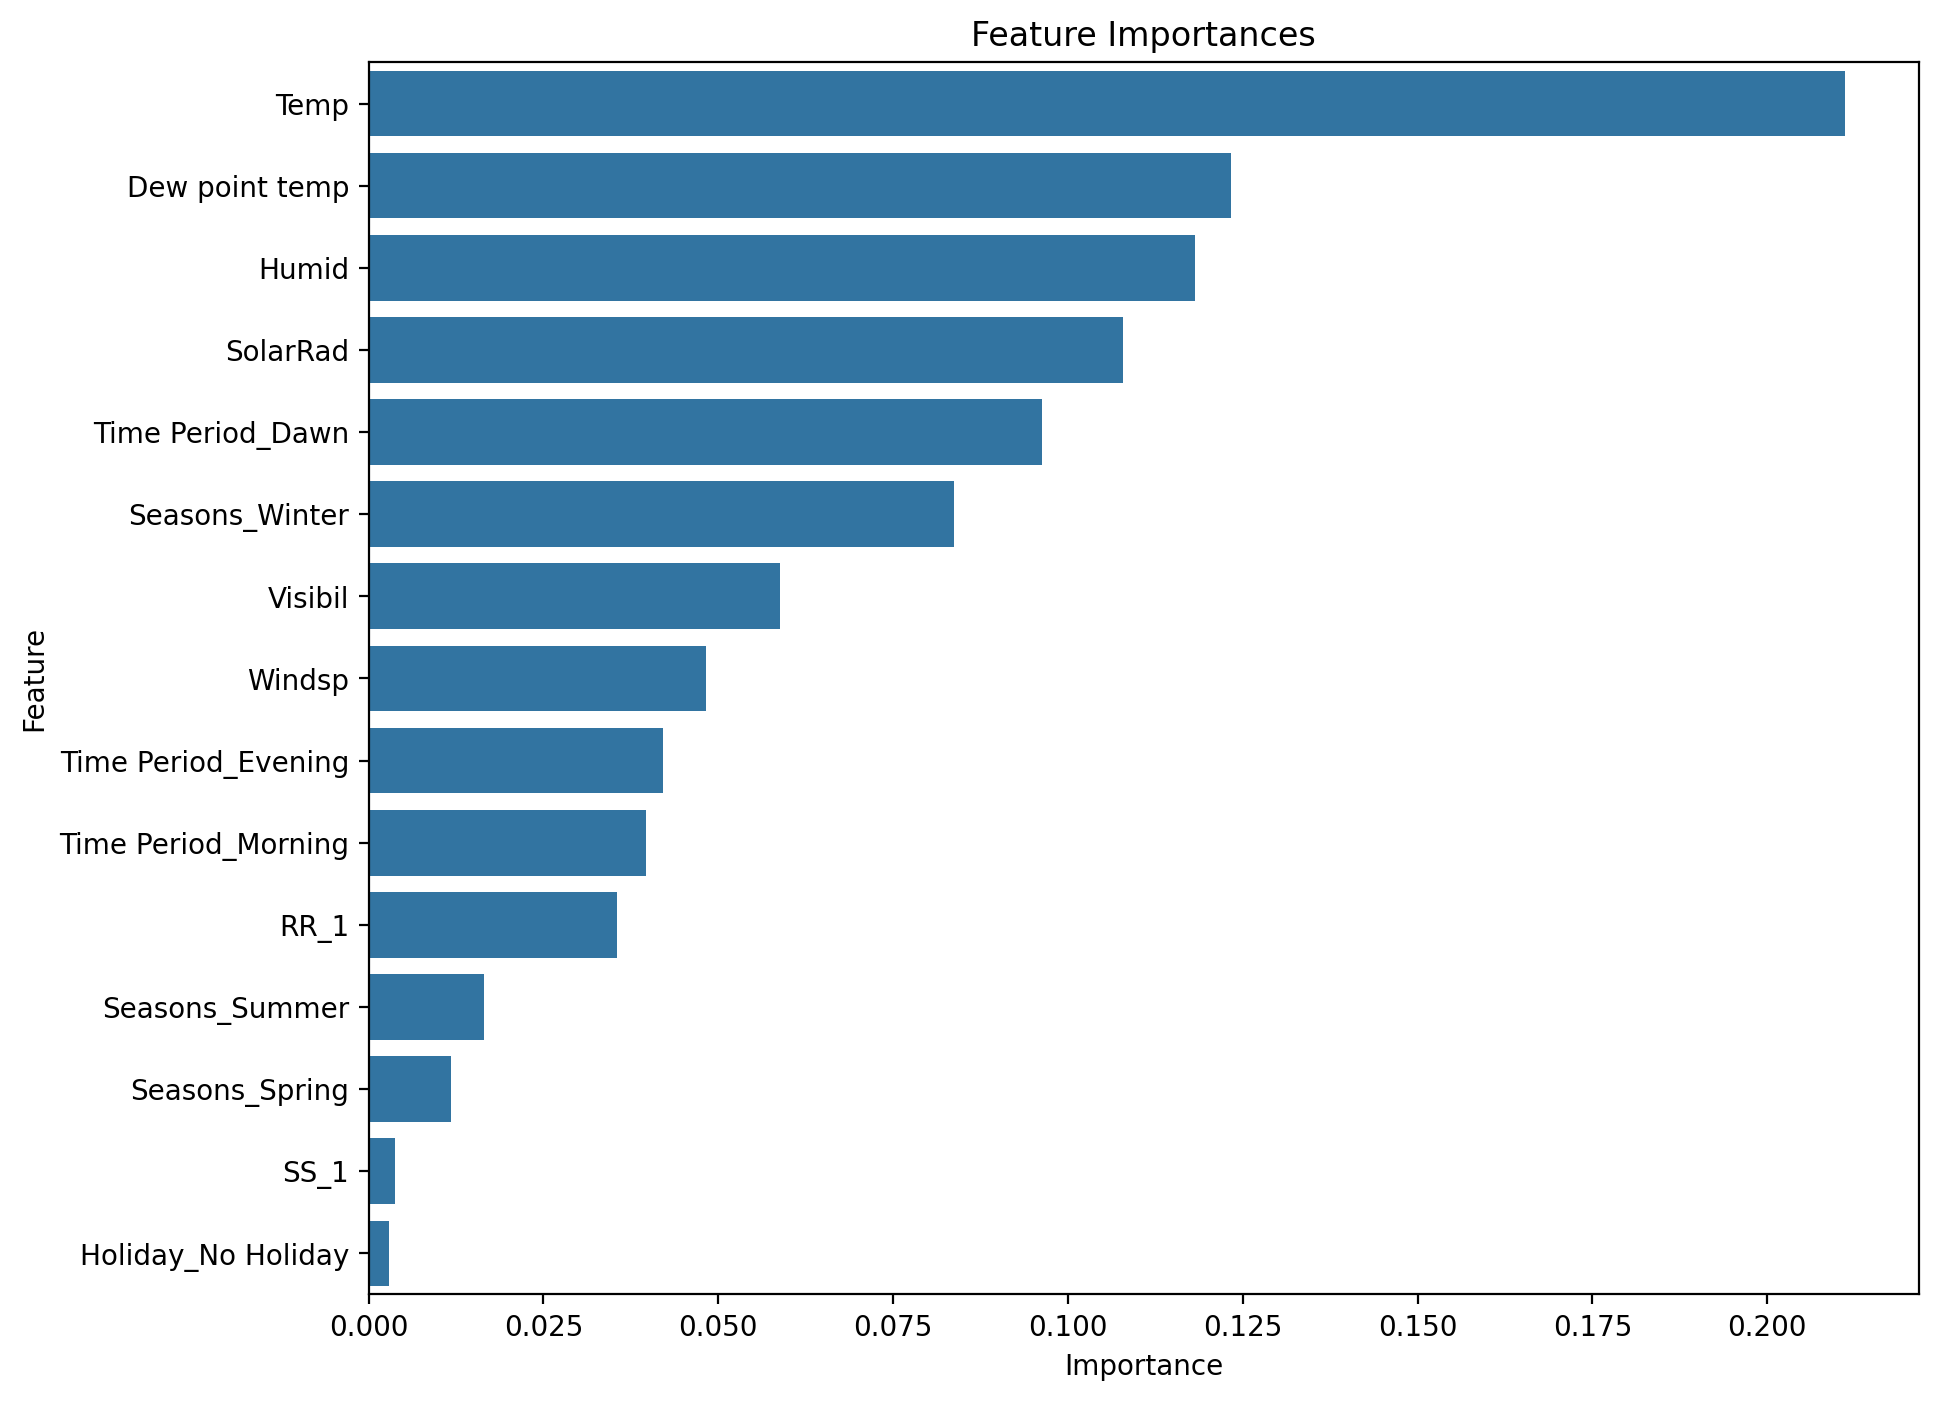

In [777]:
# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x=importances_values, y=importances_values.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- `기온`가 가장 중요한 변수로 나타나며, 모델 예측에 가장 큰 영향을 미치고 있다. 이 데이터셋에서 온도가 주요한 예측 요인임을 보여준다.
- `녹는점``태양복사량``상대습도`도 모델 예측에 기여도가 높은데, 기온과 상관관계가 높은 변수이기 때문에, 기온과 비례하게 중요한 변수로 나타났나고 생각한다. 
- `새벽시간대``계절-겨울` 변수도 데이터가 모델의 결과에 큰 역할을 하고 있다. 앞선 EDA에서 확인했을 때, 새벽시간대와 겨울일 때의 대여량이 다른 시간대/계절 보다 눈에 띄게 낮았기 때문에 나타난 결과라고 생각한다. 
- `강수량` 비가 올 경우 자전거를 이용하는 사람들의 수가 줄어들 가능성이 크기 때문에 강수량 변수는 대여량 예측에 중요한 요소로 나타났다.

## 7. 최종모델

In [778]:
# 모델 선언 
final_model = best_model_2

# 모델 학습 
final_model.fit(X_train, y_train)


# test 데이터의 대여량 예측
test['Rent'] = 9999
test['Rent'] = np.round(final_model.predict(x_test),0) # 소수점까지 예측해서 > 반올리 시키기

In [779]:
test[test['Rent'] == 9999 ] 
# 예측값이 모두 채워졌음을 확인

,Temp,Humid,Windsp,Visibil,Dew point temp,SolarRad,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Time Period_Dawn,Time Period_Evening,Time Period_Morning,RR_1,SS_1,Rent


In [780]:
test.to_csv('Bike_test_예측완료.csv', index = False)